<a href="https://colab.research.google.com/github/I-Benavides/CSCI164Proj/blob/main/164_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras.models import load_model
from tensorflow.keras.callbacks import *
import dlib
import random



In [ ]:
train_dir = "/content/drive/MyDrive/158 dataset" #passing the path of our input dataset which was downloaded and then added to drive.

In [ ]:
from google.colab import drive # Accept the permissions to access input folder
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
img_size = 96 #original size of the image
epochs = 60 #Number of trials to train the model.
batch_size = 96
lr=0.001

In [ ]:
train_datagen = ImageDataGenerator(
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [ ]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = train_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )

Found 788 images belonging to 7 classes.
Found 194 images belonging to 7 classes.


In [ ]:
model= tf.keras.models.Sequential()
# Add a convolutional layer with 32 filters, a 3x3 kernel, using relu activation, and specifying input shape
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(img_size, img_size,1)))
# Add another convolutional layer with 64 filters and relu activation
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
# Add batch normalization to normalize the activations of the previous layer
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
# Add dropout to prevent overfitting by randomly setting input units to 0 at each update during training time
model.add(Dropout(0.25))
# Repeat similar blocks with increased filter size for added depth
model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# Layer with high number of filters and regularization
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# Another identical layer as the previous one for deep feature extraction
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# Flatten the output from the convolutional layers to feed into the dense layers
model.add(Flatten())
# Fully connected layer with 256 neurons
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
# Another dense layer with 512 neurons
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
# Output layer with 7 classes using softmax activation for multi-class classification
model.add(Dense(7, activation='softmax'))
# Compile the model with Adam optimizer and categorical crossentropy as the loss function
model.compile(
    optimizer = Adam(lr=lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )
# Generate a summary of the model's architecture
model.summary()


In [ ]:
checkpoint = ModelCheckpoint('model_raw.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False,
                             restore_best_weights=True,
                             period=1)

In [ ]:
history = model.fit(x = train_generator,epochs = epochs,
                    validation_data = validation_generator,
                   callbacks=checkpoint)

In [ ]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
model = load_model("model_raw.h5")

In [ ]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

In [ ]:
model.save_weights('model_raw_weights.h5')

In [ ]:
# Load a couple of random images from the training dataset
def load_random_images(directory, num_images=2):
    images = []
    labels = []
    for subdir, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(subdir, file)
            label = os.path.basename(subdir)
            image = cv2.imread(file_path)
            images.append(image)
            labels.append(label)
    # Randomly select num_images images
    selected_indices = random.sample(range(len(images)), num_images)
    selected_images = [images[i] for i in selected_indices]
    selected_labels = [labels[i] for i in selected_indices]
    return selected_images, selected_labels

# Display the random images
def display_random_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(10, 5))
    for i, (image, label) in enumerate(zip(images, labels)):
        axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[i].set_title(label)
        axes[i].axis('off')
    plt.show()

# Load and display random images
random_images, random_labels = load_random_images(train_dir)
display_random_images(random_images, random_labels)

In [ ]:
# Load the trained model
model = load_model("model_raw.h5")
model.load_weights('model_raw_weights.h5')

# Preprocess the random images
def preprocess_images(images):
    processed_images = []
    for img in images:
        # Convert to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Resize to the required input size
        img_resized = cv2.resize(gray_img, (96, 96))
        # Normalize pixel values
        img_normalized = img_resized / 255.0
        # Add channel dimension
        img_processed = np.expand_dims(img_normalized, axis=-1)
        processed_images.append(img_processed)
    return np.array(processed_images)

# Predict classes for the random images
def predict_classes(images):
    preprocessed_images = preprocess_images(images)
    predictions = model.predict(preprocessed_images)
    # Get the predicted class index for each image
    predicted_classes = np.argmax(predictions, axis=1)
    return predicted_classes

# Enhance images based on predicted classes
def enhance_images(images, predicted_classes):
    enhanced_images = []
    for img, label in zip(images, predicted_classes):
        # Convert to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Apply histogram equalization for contrast enhancement
        img_eq = cv2.equalizeHist(gray_img)
        # Convert back to RGB
        img_rgb = cv2.cvtColor(img_eq, cv2.COLOR_GRAY2RGB)
        # Apply some color
        img_colored = cv2.applyColorMap(img_rgb, cv2.COLORMAP_JET)  # Adjust colormap as needed
        enhanced_images.append(img_colored)
    return enhanced_images

# Display the enhanced images
def display_enhanced_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 8))
    for i, img in enumerate(images):
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()

# Predict classes for the random images
predicted_classes = predict_classes(random_images)

# Enhance the images based on predicted classes
enhanced_images = enhance_images(random_images, predicted_classes)

# Display the enhanced images
display_enhanced_images(enhanced_images)


In [ ]:
train_dir1 = "/content/drive/MyDrive/enhanced_images_by_class.zip"

In [ ]:
img_size = 96 #original size of the image
epochs = 60
batch_size = 96
lr=0.001

In [ ]:
train_datagen = ImageDataGenerator(
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [ ]:
train_generator = train_datagen.flow_from_directory(directory=train_dir1,
                                                    target_size=(img_size, img_size),
                                                    batch_size=64,
                                                    color_mode="rgb",
                                                    class_mode="categorical",
                                                    subset="training"
                                                    )
validation_generator = validation_datagen.flow_from_directory(directory=train_dir1,
                                                              target_size=(img_size, img_size),
                                                              batch_size=64,
                                                              color_mode="rgb",
                                                              class_mode="categorical",
                                                              subset="validation"
                                                              )


Found 788 images belonging to 7 classes.
Found 193 images belonging to 7 classes.


In [ ]:
# This is the same model as the one we ran before so all the comments are the same
model= tf.keras.models.Sequential()
model = Sequential()

# The one difference is the input shape. It is different since with this model we are using 3 different color channels and the previous model only used 1 color channel which is grayscale.
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(img_size, img_size, 3))) # 3 means the three different color channels which are RGB
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (5, 5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

# Compile the model
model.compile(
    optimizer=Adam(lr=lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

In [ ]:
checkpoint = ModelCheckpoint('model_enhanced.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False,
                             restore_best_weights=True,
                             period=1)

In [ ]:
history = model.fit(x = train_generator,epochs = epochs,
                    validation_data = validation_generator,
                   callbacks=checkpoint)

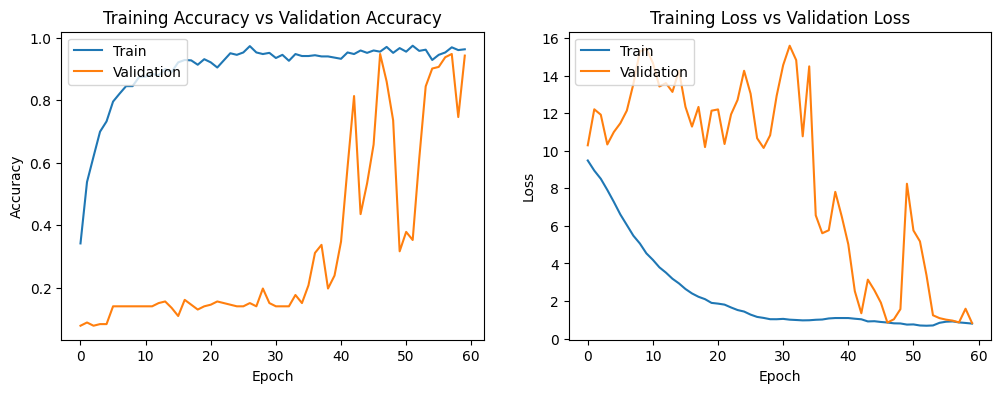

In [ ]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

4/4 [==============================] - 1s 127ms/step - loss: 0.8277 - accuracy: 0.9430
final train accuracy = 90.99 , validation accuracy = 94.30


In [ ]:
model.save_weights('model_enhanced_weights.h5')

1/1 [==============================] - 0s 376ms/step


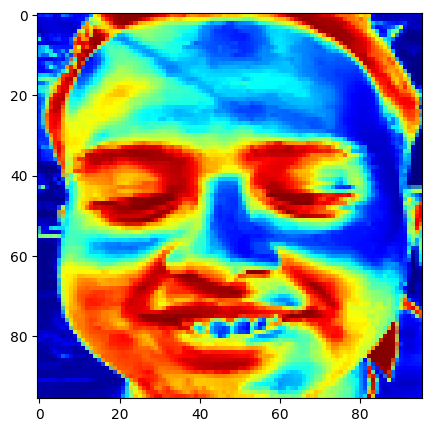

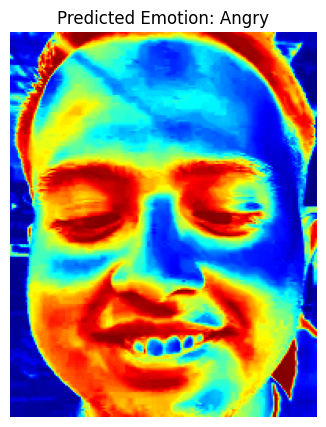

Probabilities: [8.0857784e-01 1.7226939e-01 3.6251160e-05 1.6716700e-05 1.7451741e-02
 9.3581871e-04 7.1227894e-04]
Predicted class label: Angry


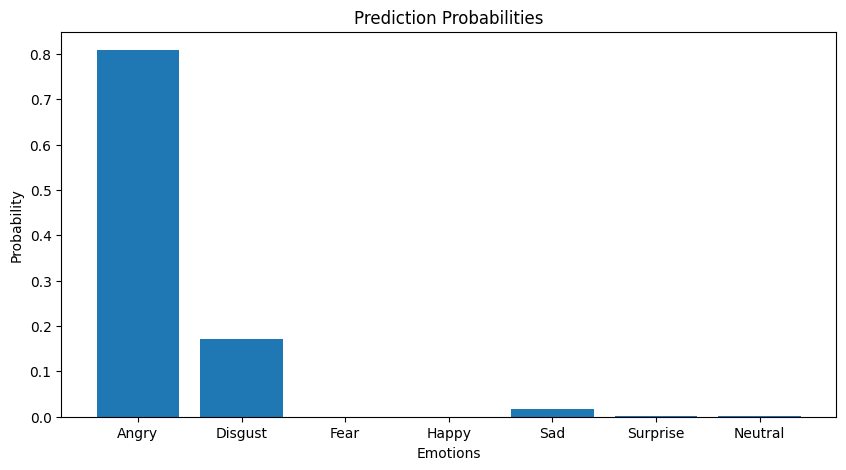

In [ ]:
# Load the trained model and its weights
model = load_model('/content/drive/MyDrive/model/model_enhanced.h5')
model.load_weights('/content/drive/MyDrive/model/model_enhanced_weights.h5')

# Define the image size expected by the model
IMG_SIZE = 96
imported_img_path = '/content/drive/MyDrive/Test_Images/alessandro.png' #upload your image into the correct directory

# Define a dictionary to map class indices to labels
class_labels = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

# Preprocess a single image
def preprocess_image(image):
    # Resize to the required input size
    img_resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    plt.figure(figsize=(10, 5))
    plt.imshow(img_resized)
    # Normalize pixel values
    img_normalized = img_resized / 255.0
    # Add channel dimension
    img_processed = np.expand_dims(img_normalized, axis=-1)
    return np.expand_dims(img_processed, axis=0)  # Add batch dimension

# Predict the class for a single image
def predict_class(image):
    preprocessed_image = preprocess_image(image)
    prediction = model.predict(preprocessed_image)
    # Get the predicted class index
    predicted_class = np.argmax(prediction, axis=1)
    return class_labels[predicted_class[0]]

# Enhance a single image
def enhance_image(image_path):
   # Load image in RGB
    rgb_img = cv2.imread(image_path)
    # Convert to grayscale
    gray_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
    # Apply histogram equalization for contrast enhancement
    img_eq = cv2.equalizeHist(gray_img)
    # Convert back to RGB
    img_rgb = cv2.cvtColor(img_eq, cv2.COLOR_GRAY2RGB)
    img_colored = cv2.applyColorMap(img_rgb, cv2.COLORMAP_JET)  # Adjust colormap as needed
    return img_colored

def predict_with_probabilities(image):
    preprocessed_image = preprocess_image(image)
    predictions = model.predict(preprocessed_image)
    class_probabilities = predictions[0]
    # Get the predicted class index
    predicted_class_index = np.argmax(class_probabilities)
    predicted_class_label = class_labels[predicted_class_index]
    return predicted_class_label, class_probabilities

# Display the enhanced image with the predicted label
def display_enhanced_image_with_label(image_path):
    enhanced_img = enhance_image(image_path)
    predicted_label, probabilities = predict_with_probabilities(enhanced_img)

    # Display the enhanced image
    plt.figure(figsize=(10, 5))
    plt.imshow(enhanced_img)
    plt.title(f'Predicted Emotion: {predicted_label}')
    plt.axis('off')
    plt.show()

    # Print the probabilities
    print(f"Probabilities: {probabilities}")
    print(f"Predicted class label: {predicted_label}")

    # Additionally, you can plot the probabilities as a bar chart if desired
    plt.figure(figsize=(10, 5))
    plt.bar(class_labels.values(), probabilities)
    plt.title('Prediction Probabilities')
    plt.ylabel('Probability')
    plt.xlabel('Emotions')
    plt.show()

# Now we can call this function with an image file path
display_enhanced_image_with_label(imported_img_path)

